# Visualizing Monetary Policy

In [1]:
! pip install pandas-datareader

In [2]:
import os
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
import matplotlib.pyplot as plt


start = datetime.datetime(1948, 1,1)
end = datetime.datetime.today()

# download data:
df = web.DataReader("GDPC1", "fred", start, end).resample("Q").mean()
df

,GDPC1
DATE,
1948-03-31,2087.442
1948-06-30,2121.899
1948-09-30,2134.056
1948-12-31,2136.440
1949-03-31,2107.001
...,...
2021-12-31,20006.181
2022-03-31,19924.088
2022-06-30,19895.271


<AxesSubplot:xlabel='DATE'>

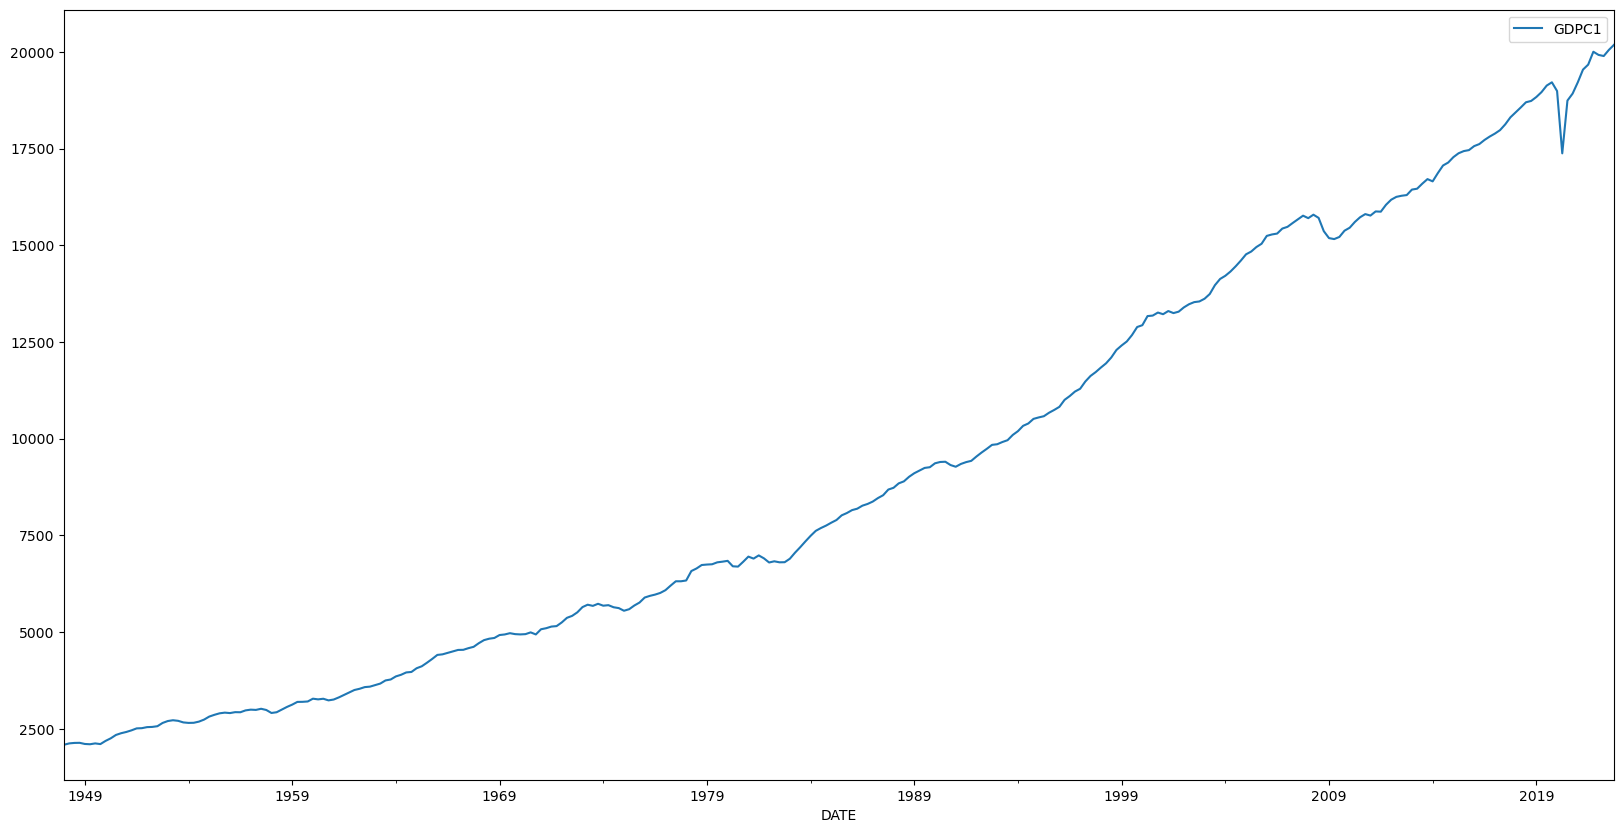

In [3]:
df.plot.line(figsize = (20,10))

In [4]:
# create a system:
def gather_data(data_codes,
               start,
                # default end to today:
               end = datetime.datetime.today(),
               freq = "M"):
    df_init = False
    for key, code in data_codes.items():
        if df_init == False:
            df = web.DataReader(
                # resample to desired frequency and take the mean
                code, "fred", start, end).resample(freq).mean() # alts: .first() or .last() or .median ...
            # rename columns to code:key
            df.rename(columns = {code:key}, inplace = True)
            df_init = True
        else:
            df[key] = web.DataReader(
                code, "fred", start, end).resample(freq).mean()
            
    return df
            

In [5]:
data_codes  = {"Base: Total": "BOGMBASEW",
               "Base: Currency in Circulation": "WCURCIR"}
start = datetime.datetime(2002, 1, 1)
end = datetime.datetime.today()
data = gather_data(data_codes = data_codes,
                  start = start,
                  end = end,
                   # set frequency to weekly
                  freq = "W")

In [6]:
data["Base: Currency in Circulation"] = data["Base: Currency in Circulation"].mul(1000)

In [7]:
# data is weekly
data.iloc[-10:]

,Base: Total,Base: Currency in Circulation
DATE,,
2020-07-12,4772522.0,1974690.0
2020-07-19,4772522.0,1978510.0
2020-07-26,4609143.0,1982873.0
2020-08-02,4609143.0,1988190.0
2020-08-09,4750981.0,1996626.0
2020-08-16,4750981.0,2003019.0
2020-08-23,4830999.0,2007458.0
2020-08-30,4830999.0,2010991.0
2020-09-06,4876690.0,2016895.0


## Breaking down the Federal Reserve's balance sheet

<AxesSubplot:xlabel='DATE'>

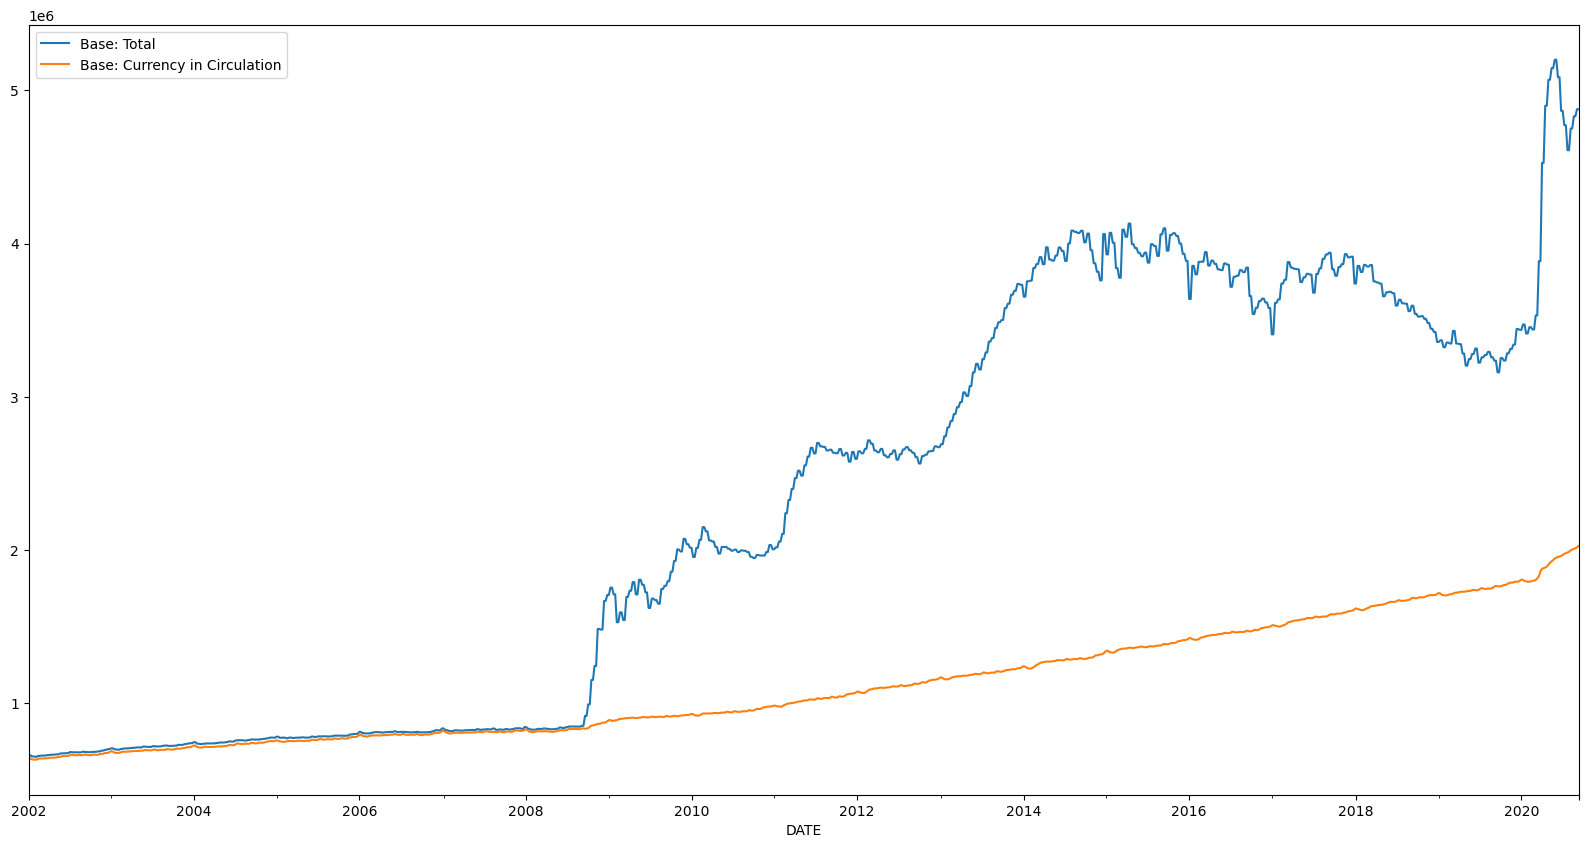

In [8]:
# identify a portion of the base vs total base
fig, ax = plt.subplots(figsize = (20,10))
data.plot.line(ax = ax)

Text(0.5, 1.0, 'Currency in Circulation')

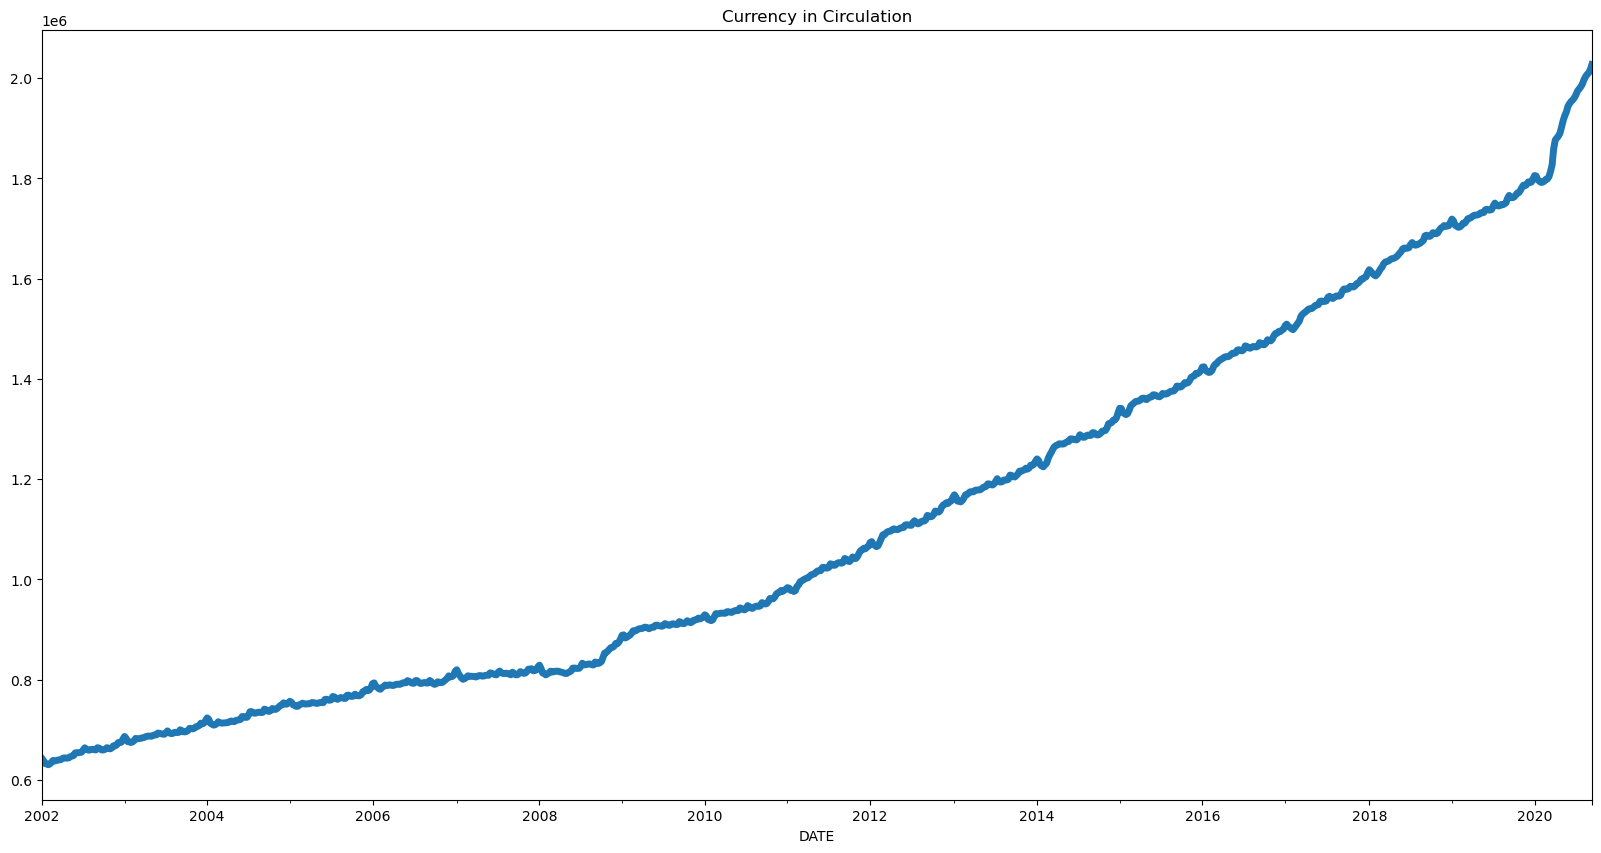

In [9]:
fig, ax = plt.subplots(figsize = (20,10))
data["Base: Currency in Circulation"].plot.line(linewidth = 5, ax = ax)
ax.set_title("Currency in Circulation")

In [10]:
# download data and breakdown the Fed's balance sheet:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               "Interest on Reserve Balances":"IORB",

               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
              }
data = gather_data(data_codes = data_codes,
                  start = start,
                  end = end,
                  freq = "M")

               

In [11]:
data.to_csv("MonetaryData.csv")

# Merge two data sets, interest on reserves at Fed, with one overlapping date

In [12]:
plot_data = data[["Interest on Reserve Balances", "Interest on Excess Reserves"]]
match = plot_data[plot_data["Interest on Reserve Balances"] == plot_data["Interest on Excess Reserves"]]
match

,Interest on Reserve Balances,Interest on Excess Reserves
DATE,,
2021-07-31,0.15,0.15


In [13]:
match_date = match.index
match_val = match.sum(axis = 1) / 2
match_date, match_val

(DatetimeIndex(['2021-07-31'], dtype='datetime64[ns]', name='DATE', freq='M'),
 DATE
 2021-07-31    0.15
 Freq: M, dtype: float64)

In [14]:
# sum the interest rate data sets
plot_data = plot_data.fillna(0)
plot_data = plot_data.sum(axis = 1)

<AxesSubplot:xlabel='DATE'>

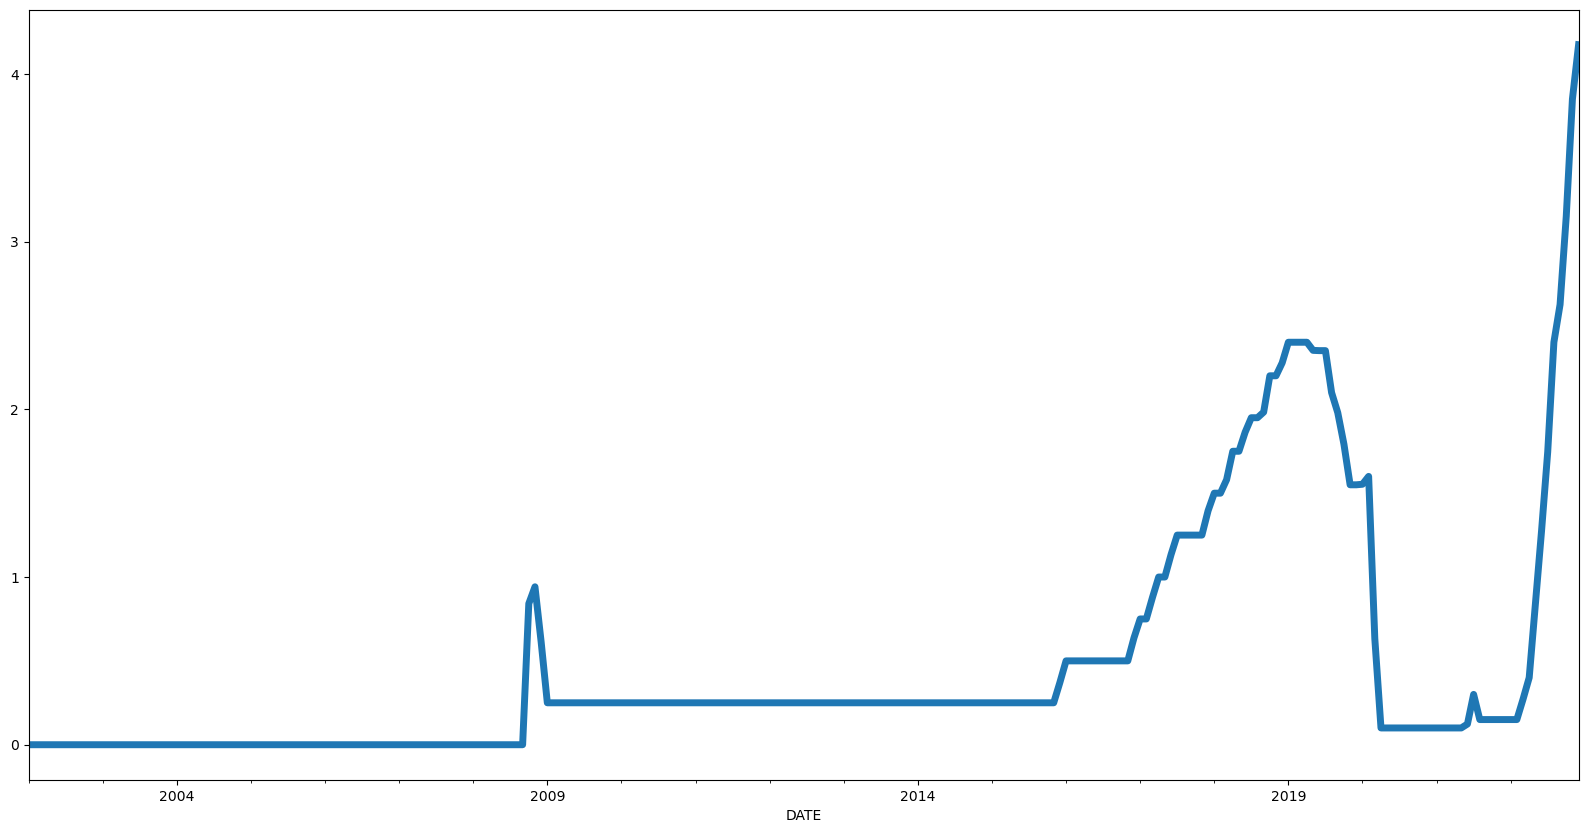

In [15]:
fig, ax = plt.subplots(figsize = (20,10))

plot_data.plot.line(linewidth = 5, ax = ax)

#data["Interest on Reserves"] = data["Interest on Excess Reserves"].fillna(0).add(
    #data["Interst on Reserve Balances"])

<AxesSubplot:xlabel='DATE'>

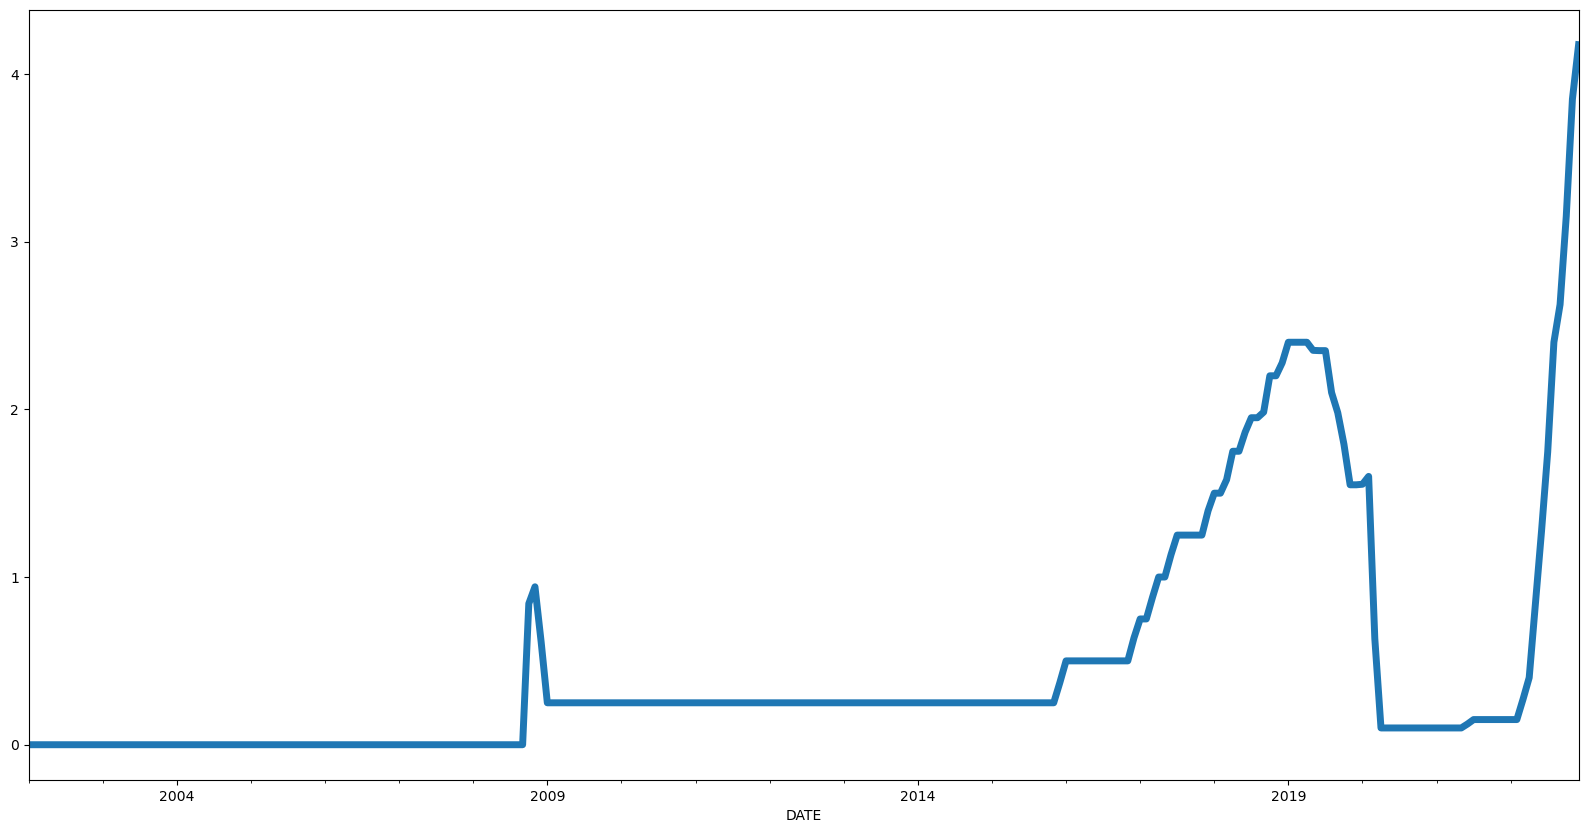

In [16]:
# get rid of overlap
plot_data.loc[match_date]= match_val
fig, ax = plt.subplots(figsize = (20,10))

plot_data.plot.line(linewidth = 5, ax = ax)

In [17]:
# add the plot data to original data
data["Interest on Reserve Balances"] = plot_data
data[["Interest on Reserve Balances"]]

,Interest on Reserve Balances
DATE,
2002-01-31,0.000000
2002-02-28,0.000000
2002-03-31,0.000000
2002-04-30,0.000000
2002-05-31,0.000000
...,...
2022-08-31,2.400000
2022-09-30,2.625000
2022-10-31,3.150000


# Create a function that plots lines of data in dataframe:

/var/folders/3j/6nrfh83n4n5dgx0fgb3pdh9c0000gn/T/ipykernel_66498/1447047824.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in y_vals])
/var/folders/3j/6nrfh83n4n5dgx0fgb3pdh9c0000gn/T/ipykernel_66498/1447047824.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(y) + "%" for y in ax.get_yticks()])


[Text(0, -1.0, '-1.0%'),
 Text(0, 0.0, '0.0%'),
 Text(0, 1.0, '1.0%'),
 Text(0, 2.0, '2.0%'),
 Text(0, 3.0, '3.0%'),
 Text(0, 4.0, '4.0%'),
 Text(0, 5.0, '5.0%'),
 Text(0, 6.0, '6.0%')]

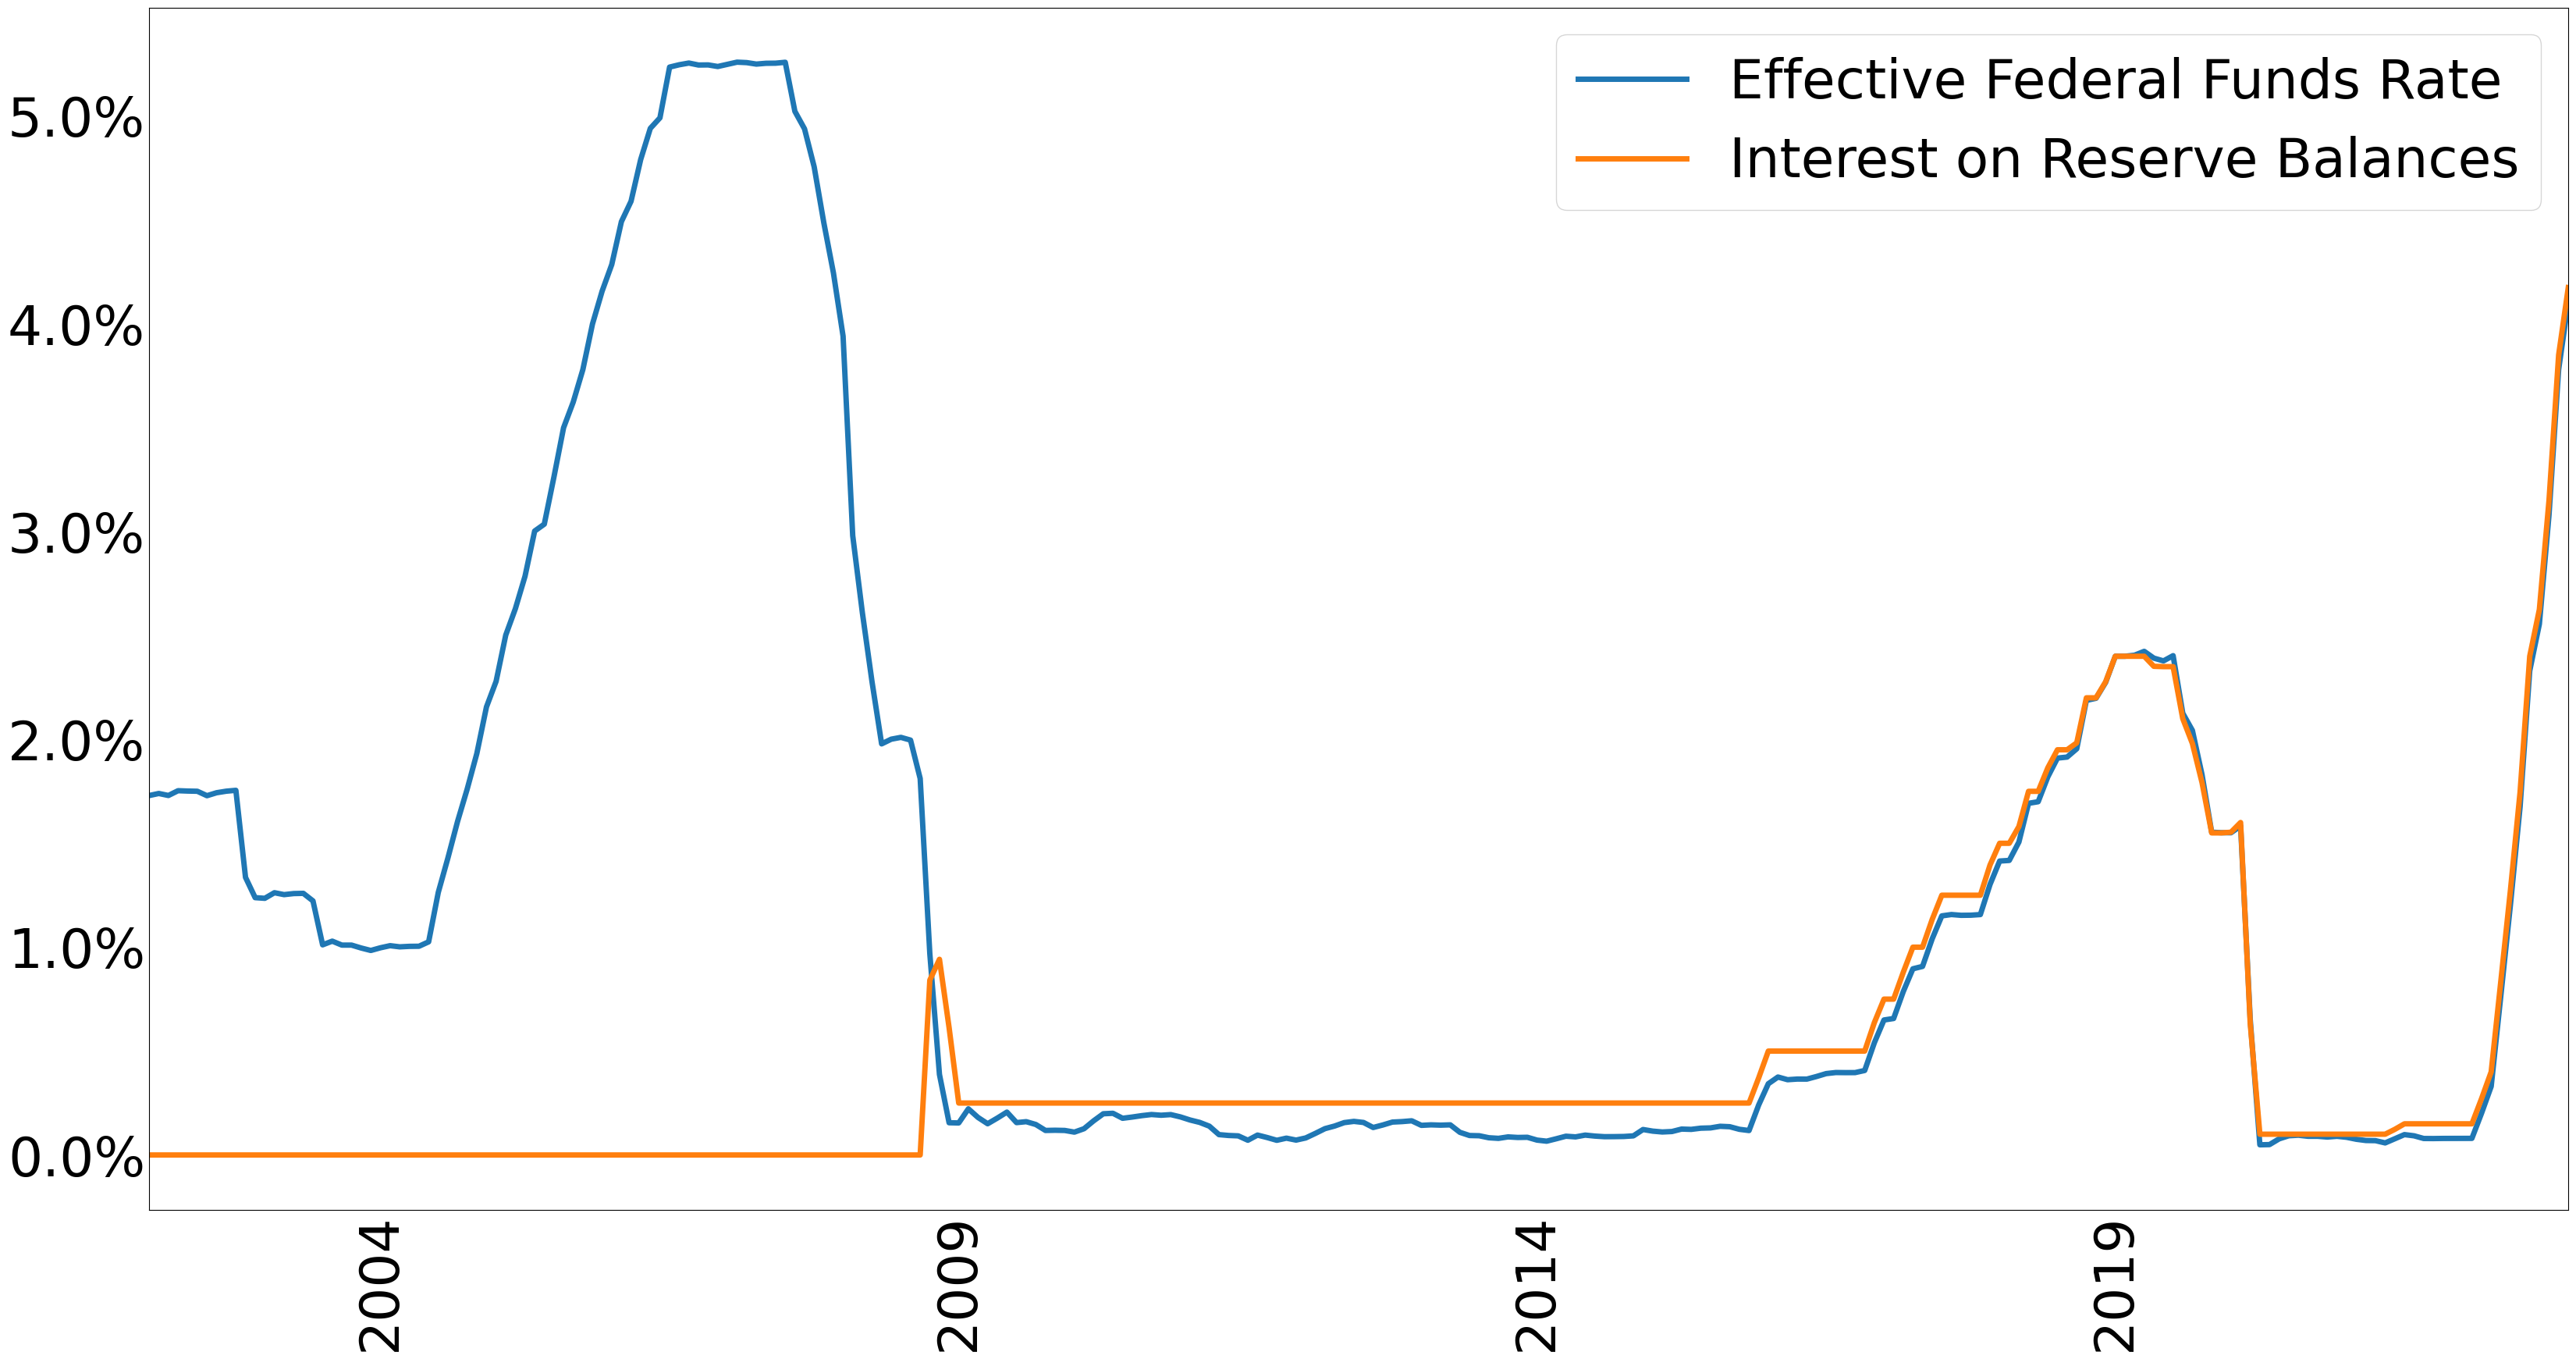

In [18]:
import os
# call a function and set parameters:
def plot_lines(df,
              linewidth = 5,
              figsize = (40,20),
              secondary_y = None,
              legend = True,
              pp = None,
              save_fig = False,
               global_fontsize = 50):
    plt.rcParams.update({"font.size":global_fontsize})
    # generate a fig and ax
    fig, ax = plt.subplots(figsize = figsize)
    # drop null values:
    df.dropna(axis = 0, how = "all").plot.line(
        linewidth = linewidth,
        ax = ax,
        secondary_y = secondary_y,
        legend = legend)
    # remove label "DATE"
    ax.set_xlabel("")
    # rotate tick labels
    ax.tick_params(axis = "x", rotation = 90)
    # get rid of ticklines
    ax.tick_params(length= 0, which= 'both')
    # round axis tick values
    # 1. access values
    y_vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in y_vals])
    
    # save figure as file
    remove_chars = "[]:$'\\'"
    filename = str(list(df.keys()))
    # remove characters from filename
    for char in remove_chars:
        filename = filename.replace(char,"")
    if save_fig:
        folder = ("Monetary Plots")
        try:
            os.mkdir(folder)
        except:
            pass
        plt.savefig(folder + "/" + filename[:50] + " line.png",
                   bbox_inches = "tight")
    
    return fig, ax

plot_data = (data[["Effective Federal Funds Rate",
                          "Interest on Reserve Balances"]])
fig, ax = plot_lines(plot_data, save_fig = True)
ax.set_yticklabels([str(y) + "%" for y in ax.get_yticks()])
    

# Monetary Base

The total monetary base can be described in terms of its support of lending within the economy.  The remainder of the base is held at the Federal Reserve without supporting additional lending. We will plot the total quantity of base money, and then break down this amount between base money that is and is not deposited at the Federal Reserve. We will observe that a radical change in monetary policy in 2008 led to an unprecedented increase in the portion of the base deposited at the Federal Reserve. 

In [20]:
# Change these from billions to millions
bill_to_mil_list = ["Balance Sheet: Total Reserves ($ Mil)",
                   "Balance Sheet: Other Deposits ($ Mil)",
                   "Base: Currency in Circulation ($ Mil)"]
for key in bill_to_mil_list:
    data[key] = data[key].mul(10 ** 3)

/var/folders/3j/6nrfh83n4n5dgx0fgb3pdh9c0000gn/T/ipykernel_66498/1447047824.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in y_vals])


(<Figure size 4000x2000 with 1 Axes>, <AxesSubplot:>)

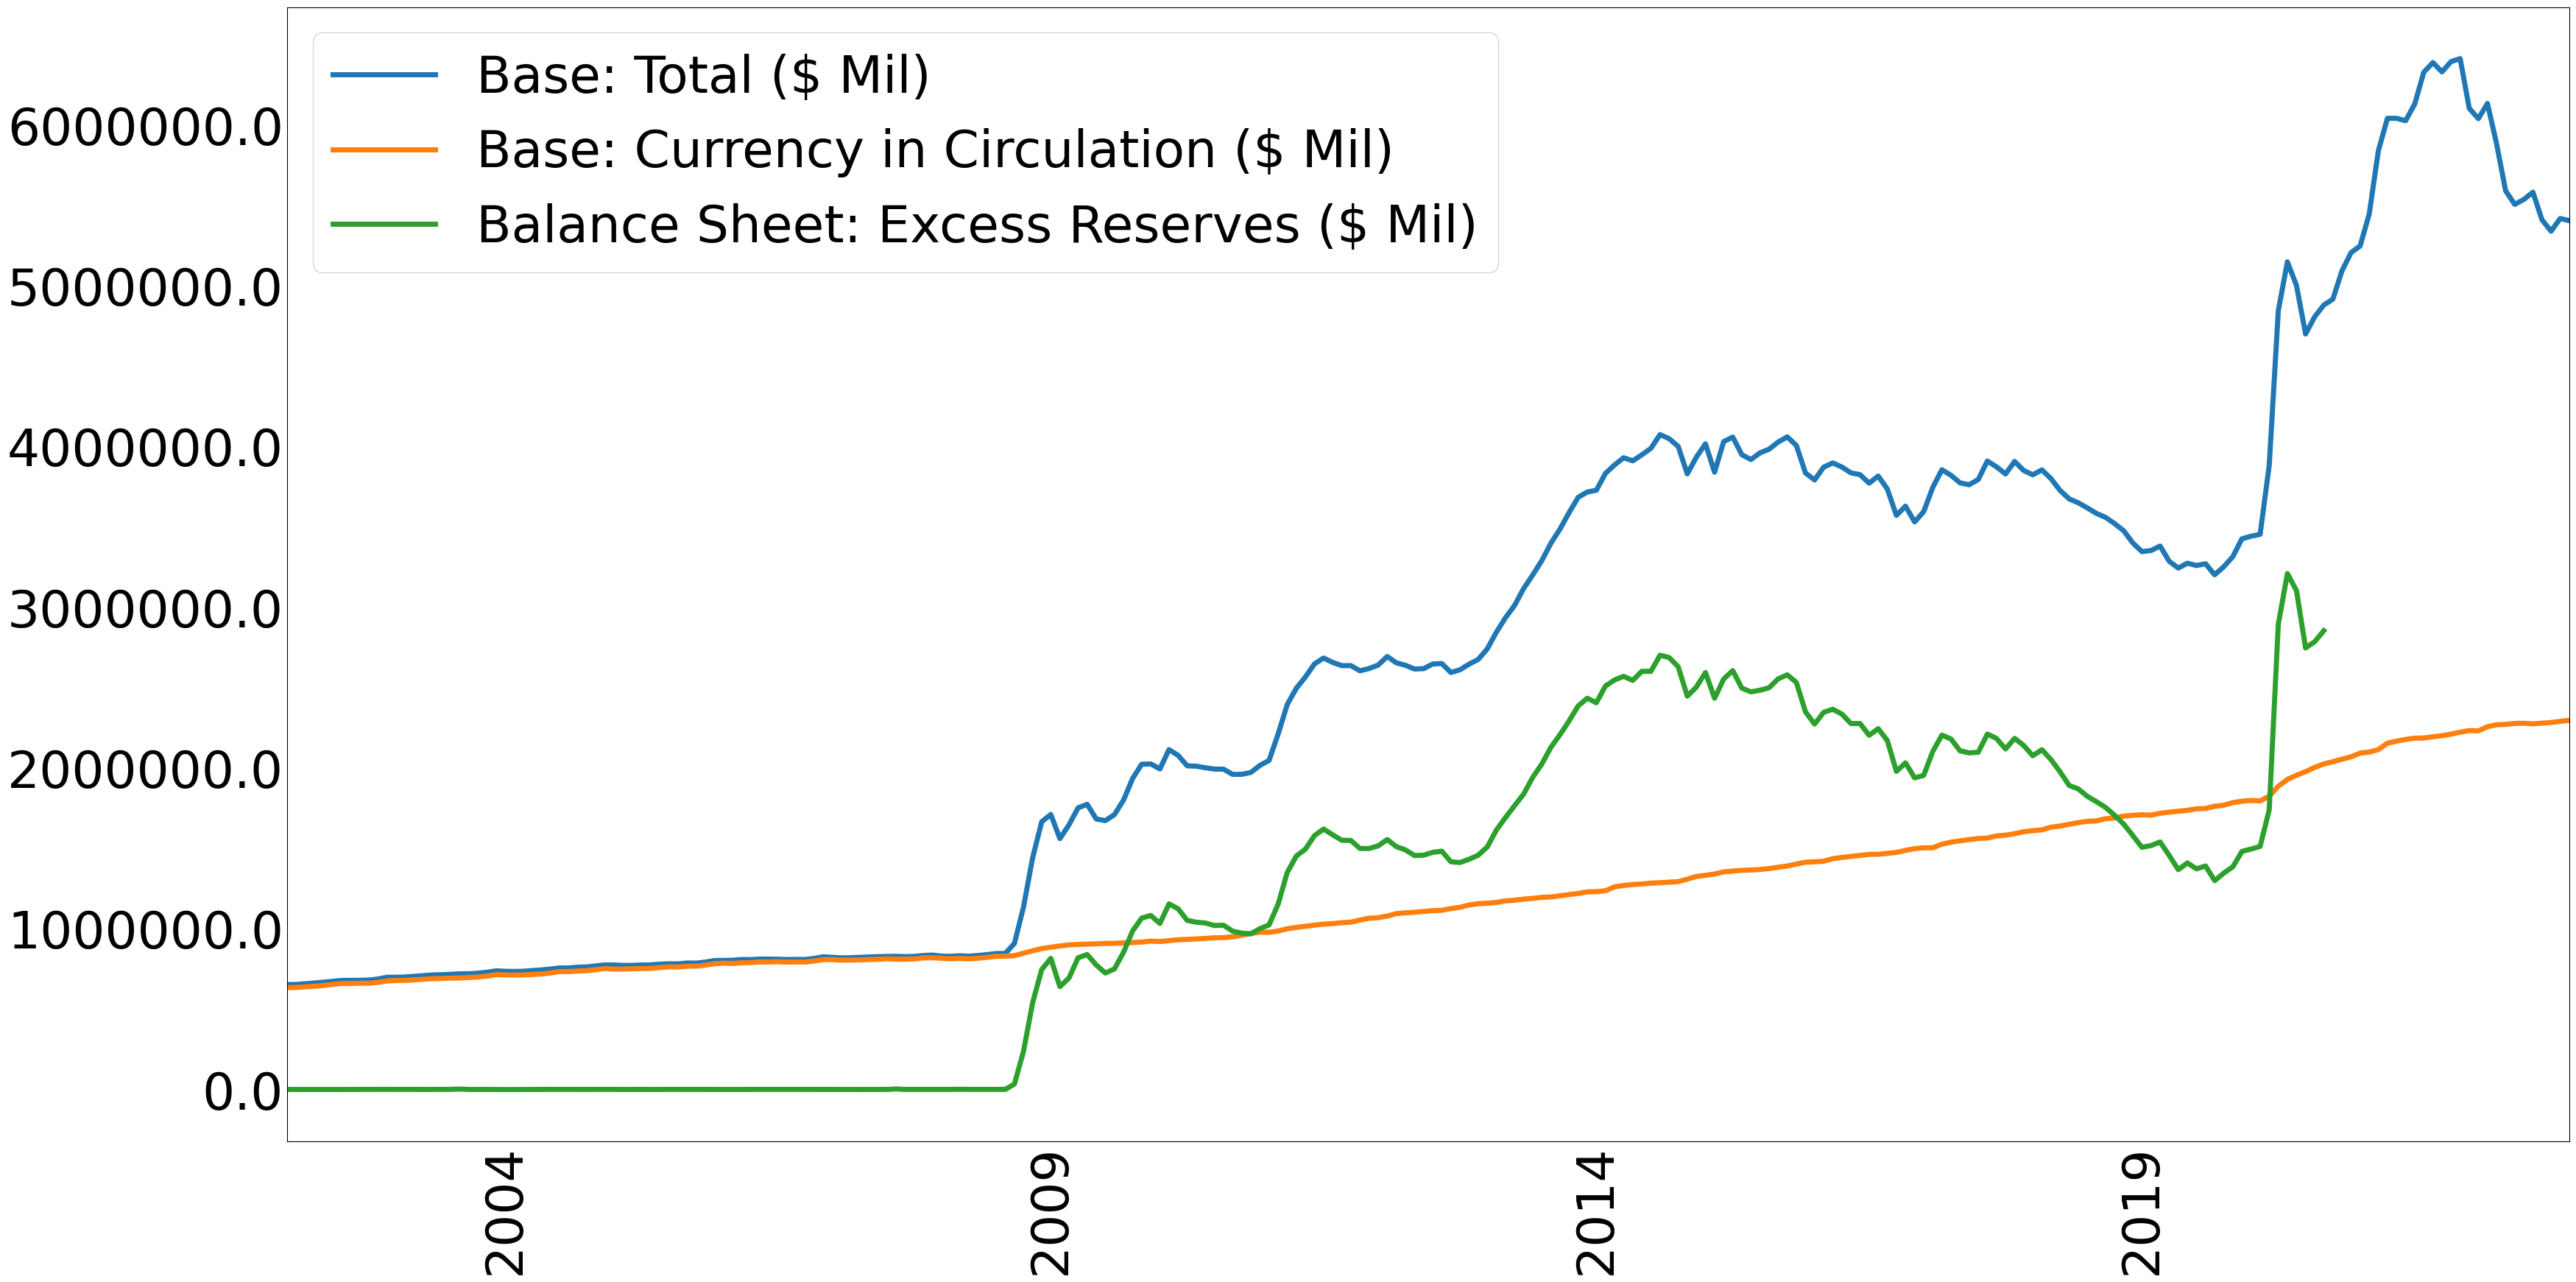

In [21]:
money_vars = ["Base: Total ($ Mil)",
              "Base: Currency in Circulation ($ Mil)",
              "Balance Sheet: Excess Reserves ($ Mil)"]
plot_data = data[money_vars]
plot_lines(df = plot_data, linewidth = 5, figsize = (40, 20), pp = None)

# Stacked lines

It would be useful if we could view these components as portions of the total stock of base money. To accomplish this, we need to create a new function in plots. This function will stack the values plotted instead of plotting the values independent of one another.

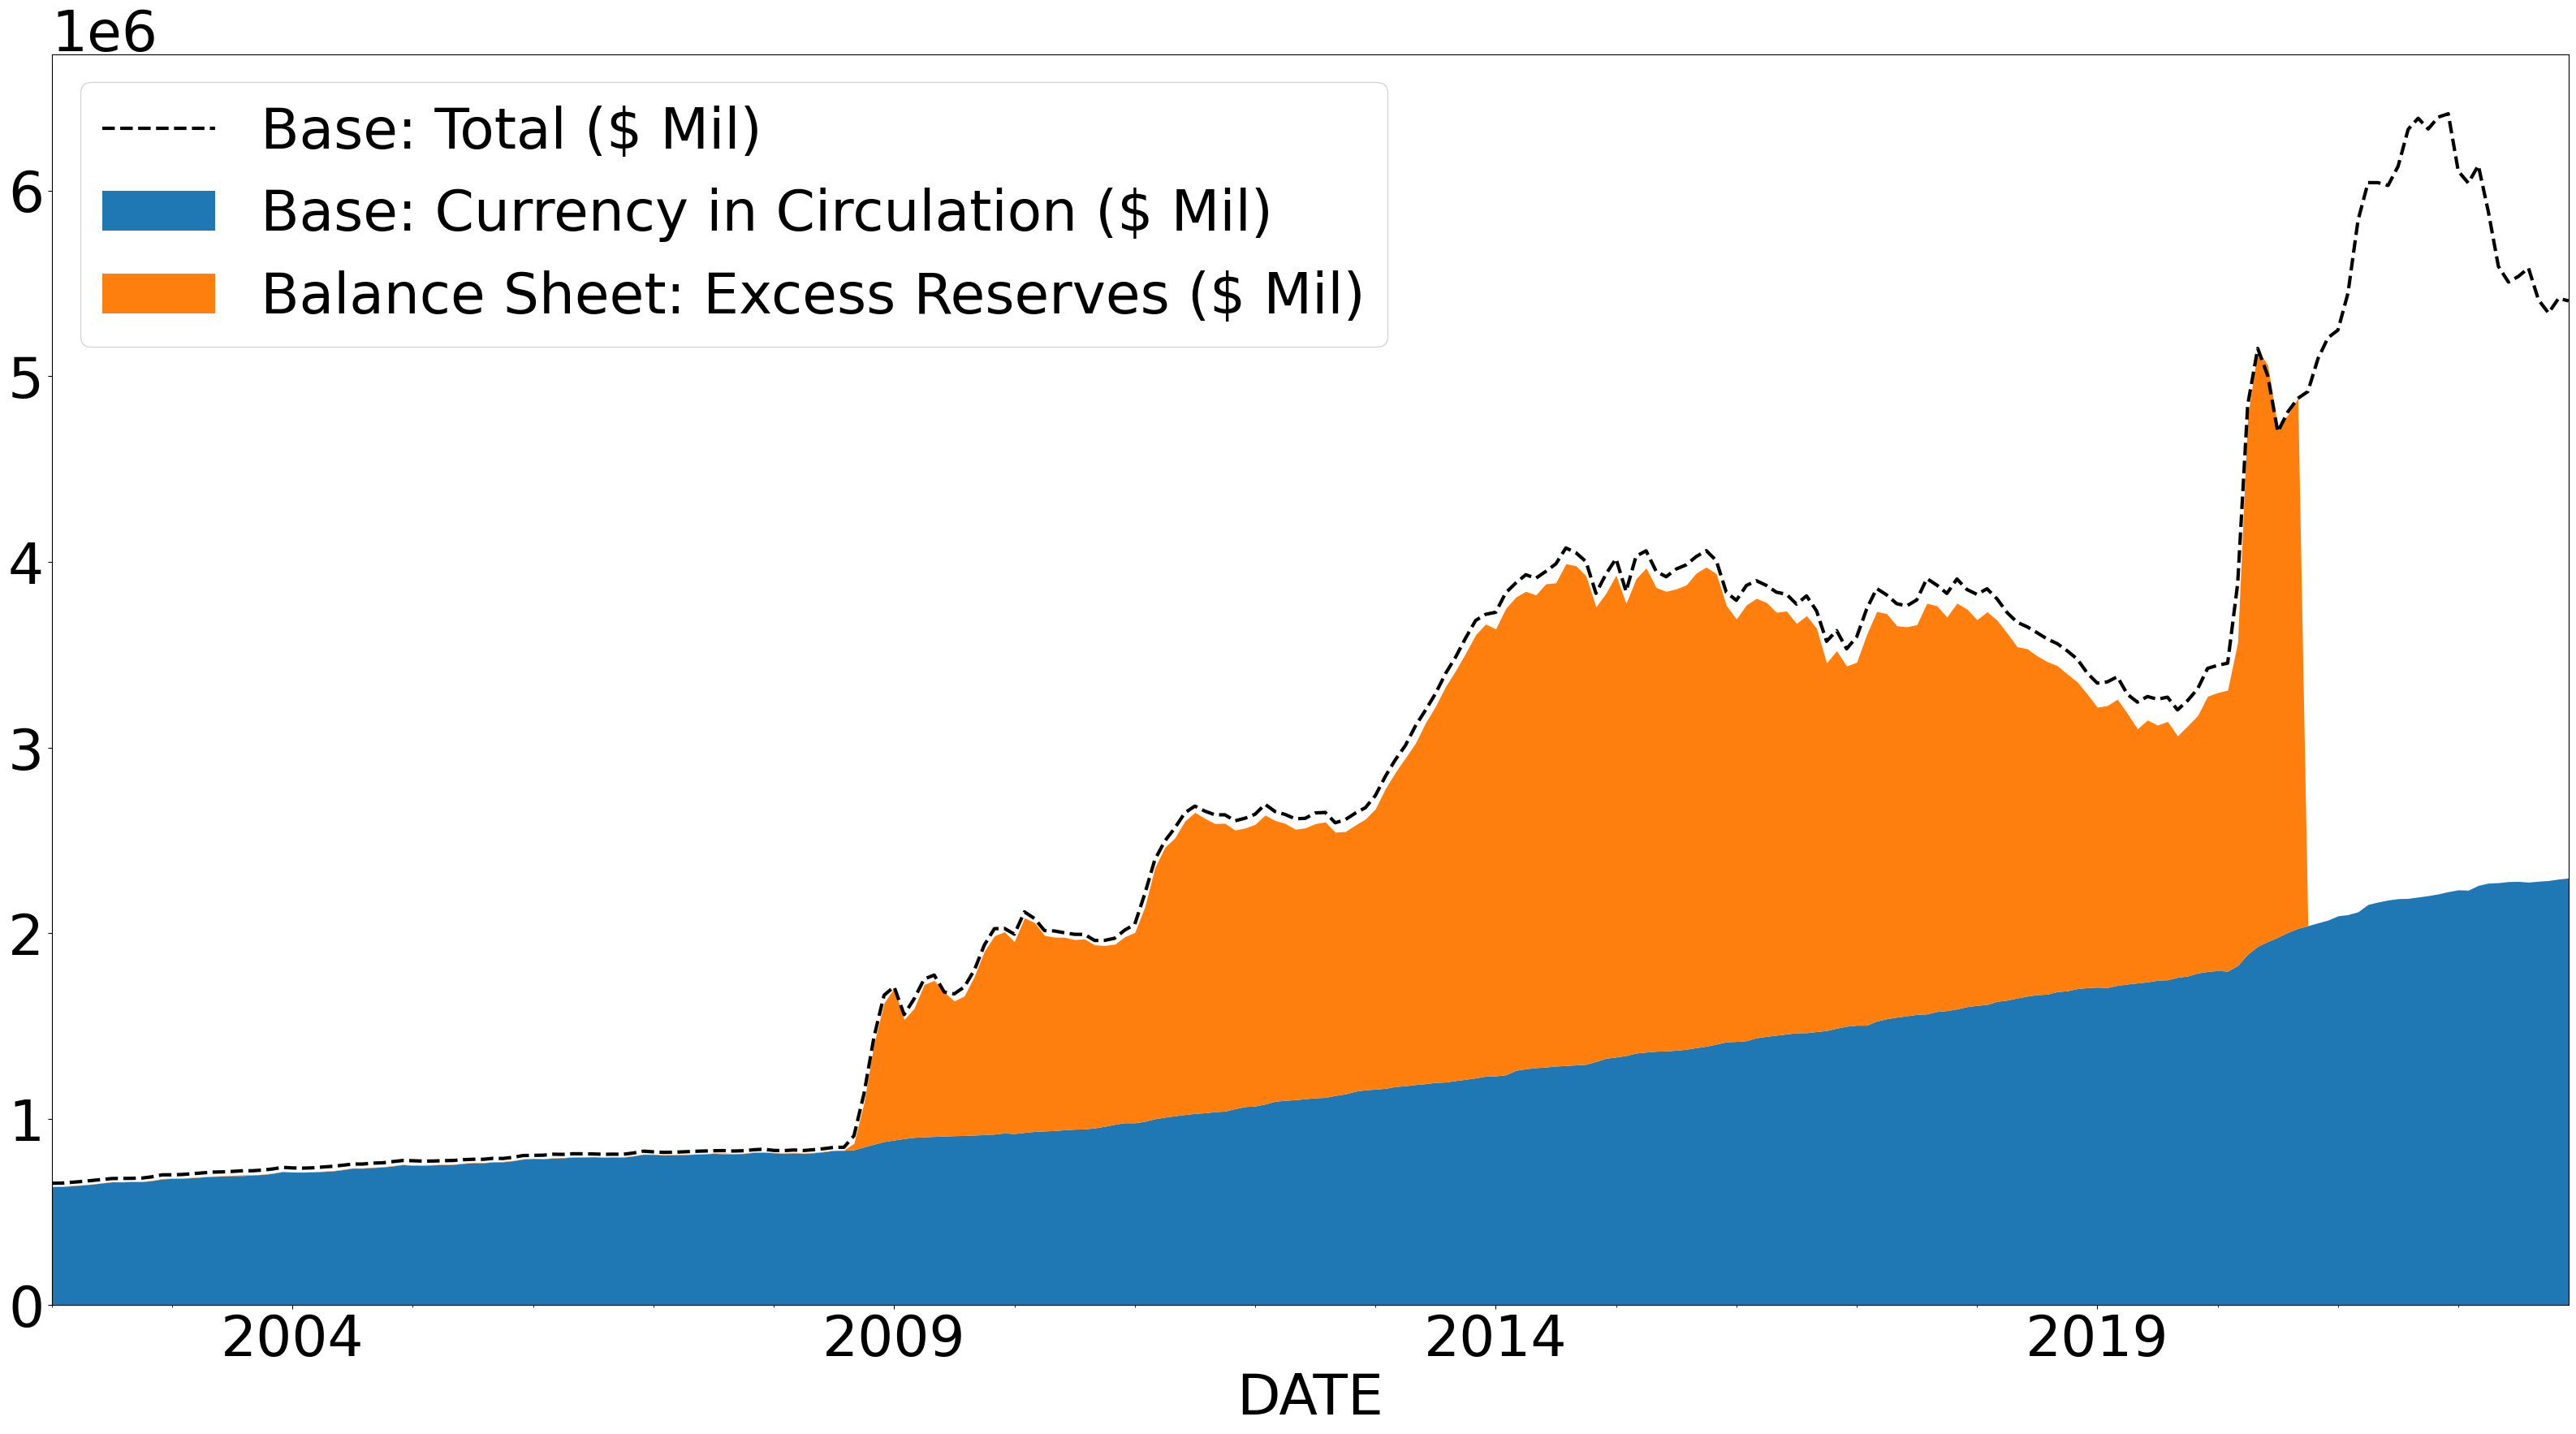

In [39]:
# make a function that plots stacked areas:
def plot_stacked(df,
                stack_vars,
                linewidth = 3,
                figsize = (40,20),
                 total_var = False,
                 global_fontsize = 50,
                 ncol = 1
                ):
    plt.rcParams.update({"font.size":global_fontsize}) # set global font size
    fig, ax = plt.subplots(figsize = figsize)
    if total_var != False: 
        df[total_var].plot.line(
            linewidth = linewidth,
            ax = ax,
            c = "k",
            label = total_var,
            ls = "--")
    ax.legend(loc = 2, ncol = ncol)
        # bbox_to_anchor = (0,1)
    # create the area plots: 
    area_df = df[stack_vars]
    area_df.plot.area(stacked = True,
                  linewidth = 0,
                  ax = ax)
    
        
    return fig, ax

stack_vars = money_vars[1:]
total_var = money_vars[0]
fig, ax = plot_stacked(df = data, stack_vars = stack_vars, total_var = total_var)

We can see that the monetary base is almost entirely divided between currency in circulation and money deposited on account as excess reserves at the Fed. The missing portion of the base in this graph is the quantity of required reserves held at the Federal Reserve. This excludes the value of required reserves held as vault cash.